In [21]:
!pip install gensim
!wget --no-check-certificate "https://ikelte-my.sharepoint.com/:u:/g/personal/natabara_inf_elte_hu/Ee9HETZu5o1BkP8EqaKtMigB_KjvuD4vQ5WpoDOG4gLISw?e=oNbmMt&download=1" -O cc.en.64.bin

--2025-04-03 16:43:31--  https://ikelte-my.sharepoint.com/:u:/g/personal/natabara_inf_elte_hu/Ee9HETZu5o1BkP8EqaKtMigB_KjvuD4vQ5WpoDOG4gLISw?e=oNbmMt&download=1
Resolving ikelte-my.sharepoint.com (ikelte-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ikelte-my.sharepoint.com (ikelte-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/natabara_inf_elte_hu/Documents/cc.en.64.bin?ga=1 [following]
--2025-04-03 16:43:31--  https://ikelte-my.sharepoint.com/personal/natabara_inf_elte_hu/Documents/cc.en.64.bin?ga=1
Reusing existing connection to ikelte-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1573176312 (1.5G) [application/octet-stream]
Saving to: ‘cc.en.64.bin’

cc.en.64.bin        100%[===================>]   1.46G  75.9MB/s    in 25s     

2025-04-03 16:43:57 (60.0 MB/s) - ‘cc.en.64.bin’ saved [1573176312/1573176312]



In [48]:
import numpy as np
import os
from collections import Counter
# import spacy
import gensim
from gensim.models.fasttext import load_facebook_model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
os.listdir('.')

['.config',
 'test.txt',
 'cc.en.64.bin',
 'val.txt',
 'train.txt',
 '.ipynb_checkpoints',
 'sample_data']

In [24]:
def csvloader(path):
    with open(path,"r") as f:
        lines = f.readlines()
    data = []
    label = []
    for line in lines:
        data.append((line.split(";")[0]).split(" "))
        label.append(line.split(";")[-1].replace("\n",""))
    return data, label

train_data, train_label = csvloader("train.txt")
val_data, val_label = csvloader("val.txt")
test_data, test_label = csvloader("test.txt")

maxlen = 0
for i in range(len(train_data)):
    sentlen = len(train_data[i])
    if sentlen>maxlen:
        maxlen=sentlen

print(maxlen)


66


In [25]:
train_data[0], train_label[0]

(['i', 'didnt', 'feel', 'humiliated'], 'sadness')

In [26]:
counter = Counter(train_label)
category_occurences = list(zip(counter.keys(), counter.values()))

category_occurences

[('sadness', 4666),
 ('anger', 2159),
 ('love', 1304),
 ('surprise', 572),
 ('fear', 1937),
 ('joy', 5362)]

In [27]:
category_dict = {x[0]:i for i, x in enumerate(category_occurences)}
category_dict

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}

In [28]:
y_train = np.array([category_dict[x] for x in train_label])
y_val = np.array([category_dict[x] for x in val_label])
y_test = np.array([category_dict[x] for x in test_label])

y_train.shape, y_val.shape, y_test.shape

((16000,), (2000,), (2000,))

In [29]:
class_weight = {0: 1.0, 1: 2.0, 2: 3.0, 3: 8.0, 4: 2.3, 5: 1.0}

In [30]:
vectors = load_facebook_model('./cc.en.64.bin').wv

In [31]:
vec = vectors.get_vector('queen', norm=True) - vectors.get_vector('woman', norm=True) + vectors.get_vector('man', norm=True)
vectors.most_similar(vec)

[('king', 0.865199863910675),
 ('queen', 0.8356119394302368),
 ('prince', 0.7777831554412842),
 ('lord', 0.7745017409324646),
 ('slayer', 0.7558771967887878),
 ('duke', 0.7390422224998474),
 ('knight', 0.7389544248580933),
 ('conquerer', 0.7211664319038391),
 ('villan', 0.7169351577758789),
 ('tyrant', 0.7153100967407227)]

In [32]:
vectors.most_similar(positive=['Budapest', 'Spain'], negative='Hungary')

[('Barcelona', 0.8969185948371887),
 ('Madrid', 0.8903045654296875),
 ('Amsterdam', 0.8504062294960022),
 ('Marseille', 0.8501889705657959),
 ('Lisbon', 0.8479151725769043),
 ('Sitges', 0.8467515110969543),
 ('Aix-en-Provence', 0.8436455726623535),
 ('Palermo', 0.8431168794631958),
 ('Bilbao', 0.8421478271484375),
 ('Cascais', 0.8316007852554321)]

In [33]:
def query_all_vectors(data: list, pad_to_length: int | None = None):
  vecs = []
  for datarow in data:
    vecrow = []
    for word in datarow:
      vecrow.append(vectors.get_vector(word, norm=False))
    if pad_to_length is not None:
      diff = pad_to_length-len(vecrow)
      if diff>0:
        vecrow += [np.zeros_like(vecrow[-1])]*diff
      elif diff < 0:
        vecrow[-1] = vecrow[-1][:diff]
    vecs.append(np.stack(vecrow))

  return np.stack(vecs)


In [34]:
padding = 70
X_train = query_all_vectors(train_data, padding)
X_val = query_all_vectors(val_data, padding)
X_test = query_all_vectors(test_data, padding)

X_train.shape, X_val.shape, X_test.shape

((16000, 70, 64), (2000, 70, 64), (2000, 70, 64))

In [35]:
class VectorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [36]:
train_dataset = VectorDataset(X_train, y_train)
val_dataset = VectorDataset(X_val, y_val)
test_dataset = VectorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
class Model(nn.Module):
    def __init__(self, in_dim: int, num_categories: int):
        super().__init__()
        self.lstm_1 = nn.LSTM(in_dim, 128, batch_first=True, bidirectional=True, dropout=0.1)
        self.lstm_2 = nn.LSTM(256, 64, batch_first=True, bidirectional=True, dropout=0.1)
        self.linear_1 = nn.Linear(128, 32)
        self.linear_2 = nn.Linear(32, num_categories)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len, in_dim)
        x, _ = self.lstm_1(x)  # -> (batch, seq_len, 256)
        x, _ = self.lstm_2(x)  # -> (batch, seq_len, 128)
        x = torch.max(x, dim=1).values  # Global max pooling over seq_len
        x = torch.tanh(self.linear_1(x))
        x = self.linear_2(x)
        return x

In [42]:
model = Model(X_train.shape[-1], len(category_dict))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [43]:
class_weight_pt = torch.tensor(list(class_weight.values()))
class_weight_pt

tensor([1.0000, 2.0000, 3.0000, 8.0000, 2.3000, 1.0000])

In [44]:
loss_fn = nn.CrossEntropyLoss(weight=class_weight_pt.to(device))
epochs = 100
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_loss = np.inf
patience = 20
early_stop_counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    train_preds = []
    train_targets = []

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        preds = torch.argmax(output, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(y.cpu().numpy())

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_acc = accuracy_score(train_targets, train_preds)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.inference_mode():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            output = model(x_val)
            loss = loss_fn(output, y_val)
            epoch_val_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(y_val.cpu().numpy())

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_acc = accuracy_score(val_targets, val_preds)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model_state = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_state)

Epoch 1/100, Train Loss: 1.7854, Train Acc: 0.3351, Val Loss: 1.7861, Val Acc: 0.3520
Epoch 2/100, Train Loss: 1.7818, Train Acc: 0.3412, Val Loss: 1.7671, Val Acc: 0.3880
Epoch 3/100, Train Loss: 1.7339, Train Acc: 0.4005, Val Loss: 1.7223, Val Acc: 0.4125
Epoch 4/100, Train Loss: 1.6853, Train Acc: 0.4208, Val Loss: 1.6741, Val Acc: 0.4280
Epoch 5/100, Train Loss: 1.6643, Train Acc: 0.4278, Val Loss: 1.6522, Val Acc: 0.4305
Epoch 6/100, Train Loss: 1.6489, Train Acc: 0.4346, Val Loss: 1.6362, Val Acc: 0.4715
Epoch 7/100, Train Loss: 1.6359, Train Acc: 0.4427, Val Loss: 1.6968, Val Acc: 0.4250
Epoch 8/100, Train Loss: 1.6276, Train Acc: 0.4457, Val Loss: 1.6128, Val Acc: 0.4640
Epoch 9/100, Train Loss: 1.6063, Train Acc: 0.4485, Val Loss: 1.5915, Val Acc: 0.4805
Epoch 10/100, Train Loss: 1.5859, Train Acc: 0.4382, Val Loss: 1.5782, Val Acc: 0.4550
Epoch 11/100, Train Loss: 1.5662, Train Acc: 0.4458, Val Loss: 1.5580, Val Acc: 0.4670
Epoch 12/100, Train Loss: 1.5464, Train Acc: 0.4444,

<All keys matched successfully>

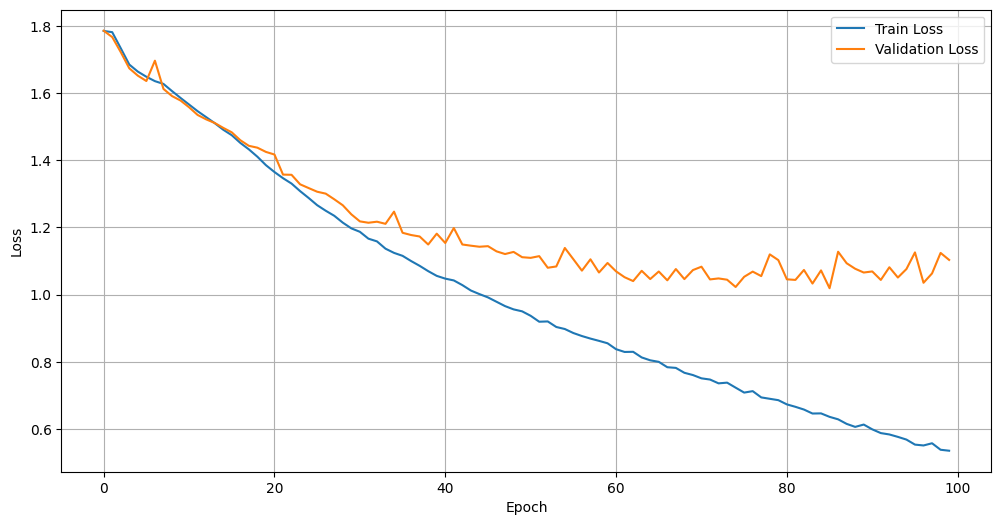

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [55]:
model.eval()
test_loss = 0.0
test_preds = []
test_targets = []

with torch.inference_mode():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = loss_fn(output, y)
        test_loss += loss.item()

        preds = torch.argmax(output, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_acc = accuracy_score(test_targets, test_preds)
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 1.0495, Test Accuracy: 0.6540


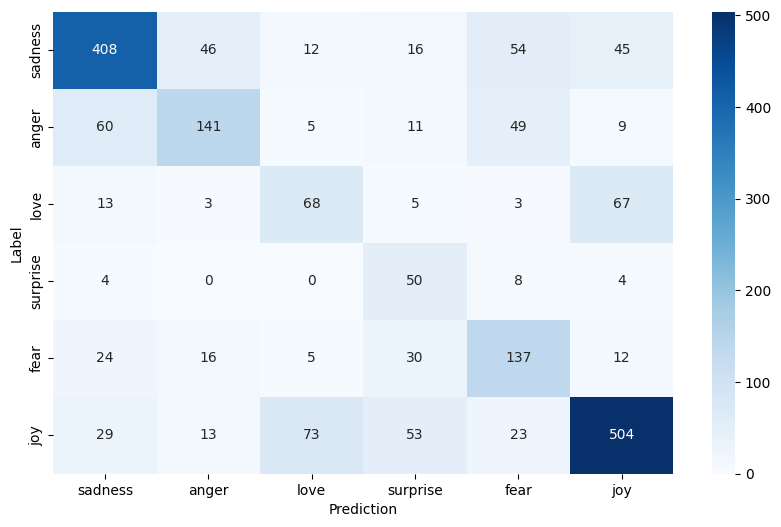

In [62]:
plt.figure(0,figsize=(10,6))
conf_matrix = confusion_matrix(test_targets, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(category_dict.keys()), yticklabels=list(category_dict.keys()))
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.show()

In [84]:
def emoji_tester(model, text):
    catDictInverse = {0:"😓",1:"👿",2:"🥰",3:"😲",4:"😱",5:"😃"}
    net_input = query_all_vectors([text.lower().split(" ")], pad_to_length=padding)
    net_input = torch.tensor(net_input, dtype=torch.float).to(device)
    net_output = model(net_input)
    net_output = net_output.cpu().detach().numpy()
    emoji = catDictInverse[np.argmax(net_output)]
    return f'{text} {emoji}'


In [90]:
emoji_tester(model, "I LOVE NLP")

'I LOVE NLP 😃'

In [103]:
emoji_tester(model, 'NLP is annoying')

'NLP is annoying 😱'